# AICadium ML Project
### Build a machine learning model to predict whether a customer will buy a product or not.

Demonstrate familiarity in multiple aspects of creating a solution, including data exploration, feature engineering, model selection, pipelines, deployment, etc.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
sns.set_style("darkgrid")

## Get Acquainted with the Dataset

In [2]:
customer_data = pd.read_csv('coding_round_data.csv')
customer_data['Revenue'] = customer_data['Revenue'].apply(lambda x: 1 if x else 0)

In [3]:
print(f'Number of Records: {len(customer_data)}')
print(f'Number of Variables: {len(customer_data.keys())}')
print(f'Any NaN values? {customer_data.isnull().values.any()}')

# Explicitly define these variables to make sure functions below are taking in the right variables
# (as opposed to doing position-based indexing, e.g. customer_data.iloc[:, 0:10])
num_vars = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', \
            'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
cat_vars = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']

customer_data.head()
# The first 10 variables are numerical, while the last 8 are categorical: {'Month', ..., 'Revenue'}.
# The column 'Revenue' contains our data labels.

Number of Records: 12330
Number of Variables: 18
Any NaN values? False


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,0


In [79]:
customer_data.describe()

# We see outliars for quite a few of these variables.

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


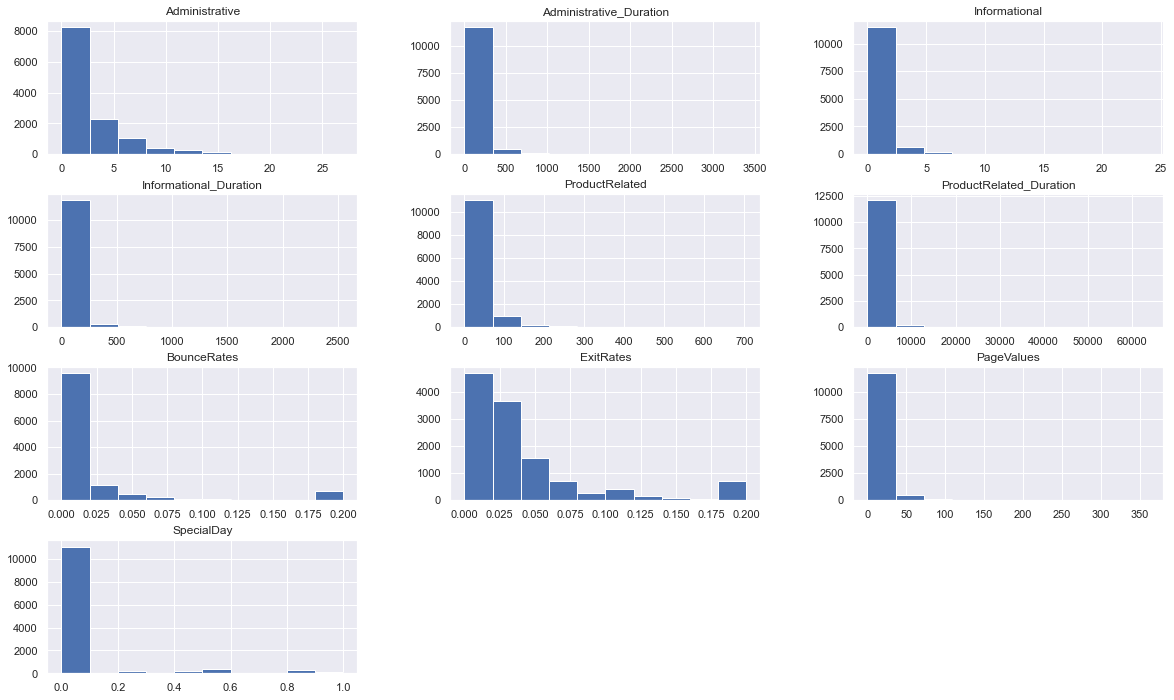

In [80]:
# Plot histograms of the numerical variables
sns.set(rc = {'figure.figsize':(20,12)})

customer_data.loc[:, num_vars].hist();

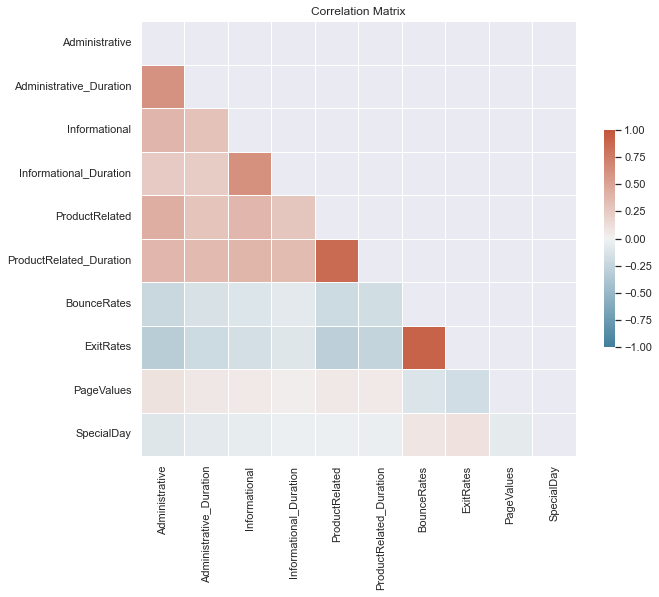

In [82]:
sns.set(rc = {'figure.figsize':(10,8)})

# Visualize a correlation matrix for the numerical variables
corr_mat = customer_data.loc[:, num_vars].corr()

# mask out the upper triangle for better viewing
mask = np.triu(np.ones_like(corr_mat, dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_mat, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0.0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});
plt.title('Correlation Matrix');

# We see high correlations between:
# - ProductRelated_Duration and ProductRelated
# - ExitRates and BounceRates

# To avoid collinearities, for each of these pairs, we should potentially pick the variable that has the higher predictive
# power w.r.t Revenue

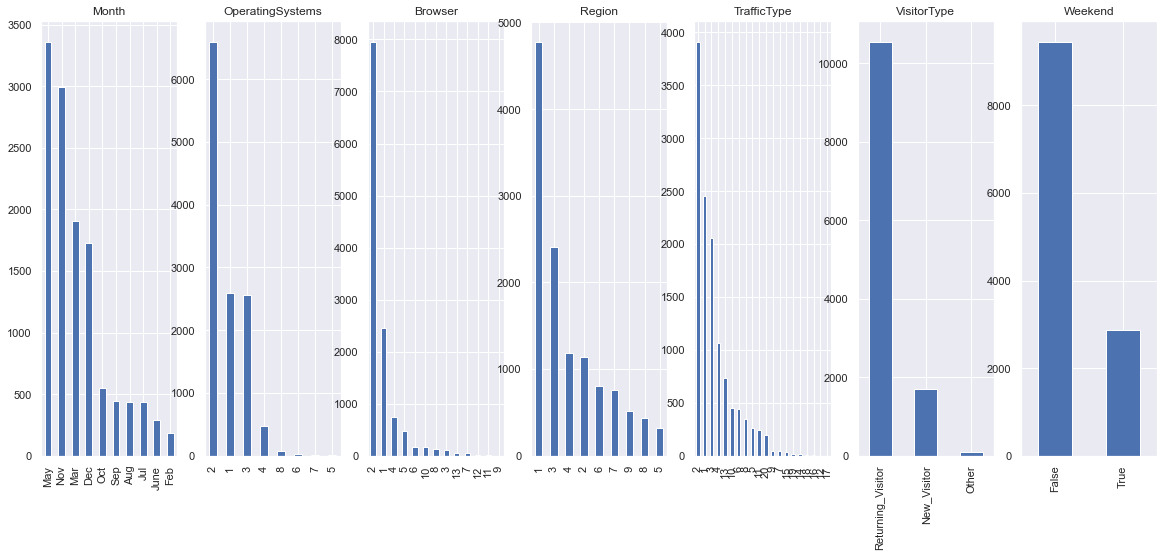

In [88]:
sns.set(rc = {'figure.figsize':(20,8)})
# Plot histograms of the categorical variables

fig, ax = plt.subplots(1, len(cat_vars))
for (i, var) in enumerate(customer_data[cat_vars]):
    customer_data[var].value_counts().plot(kind='bar', ax=ax[i]).set_title(var);
    
# look into this link:
# https://stats.stackexchange.com/questions/30406/how-to-assess-predictive-power-of-set-of-categorical-predictors-of-a-binary-outc

In [ ]:
# TODO:
# - rank features by predictive power (how to rank categorical)
# - figure out how to feed categorical variables to RandomForestClassifier
# - diagnose why all True Negatives and False negatives (no samples predicted to be True)

## Train Predictor

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

In [5]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = \
    train_test_split(customer_data.loc[:, num_vars], customer_data.loc[:, 'Revenue'], \
                     test_size=0.2, random_state=42)

In [18]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)

y_test_probs = clf.predict_proba(X_test)[:, 1] # probability of the positive class (should match clf.classes_)
confusion_matrix(y_test, clf.predict(X_test))

array([[1974,   81],
       [ 194,  217]], dtype=int64)

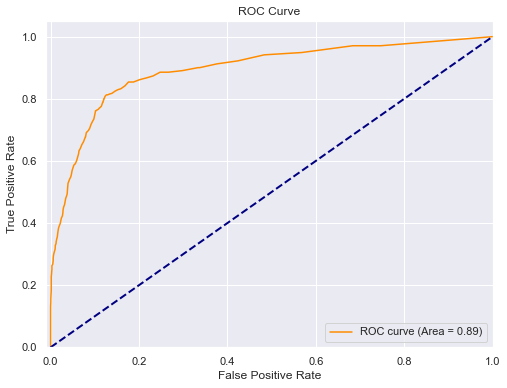

In [30]:
sns.set(rc = {'figure.figsize':(8,6)})

fpr, tpr, thresh = roc_curve(y_test, y_test_probs)

plt.figure()
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    label="ROC curve (Area = %0.2f)" % auc(fpr, tpr),
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

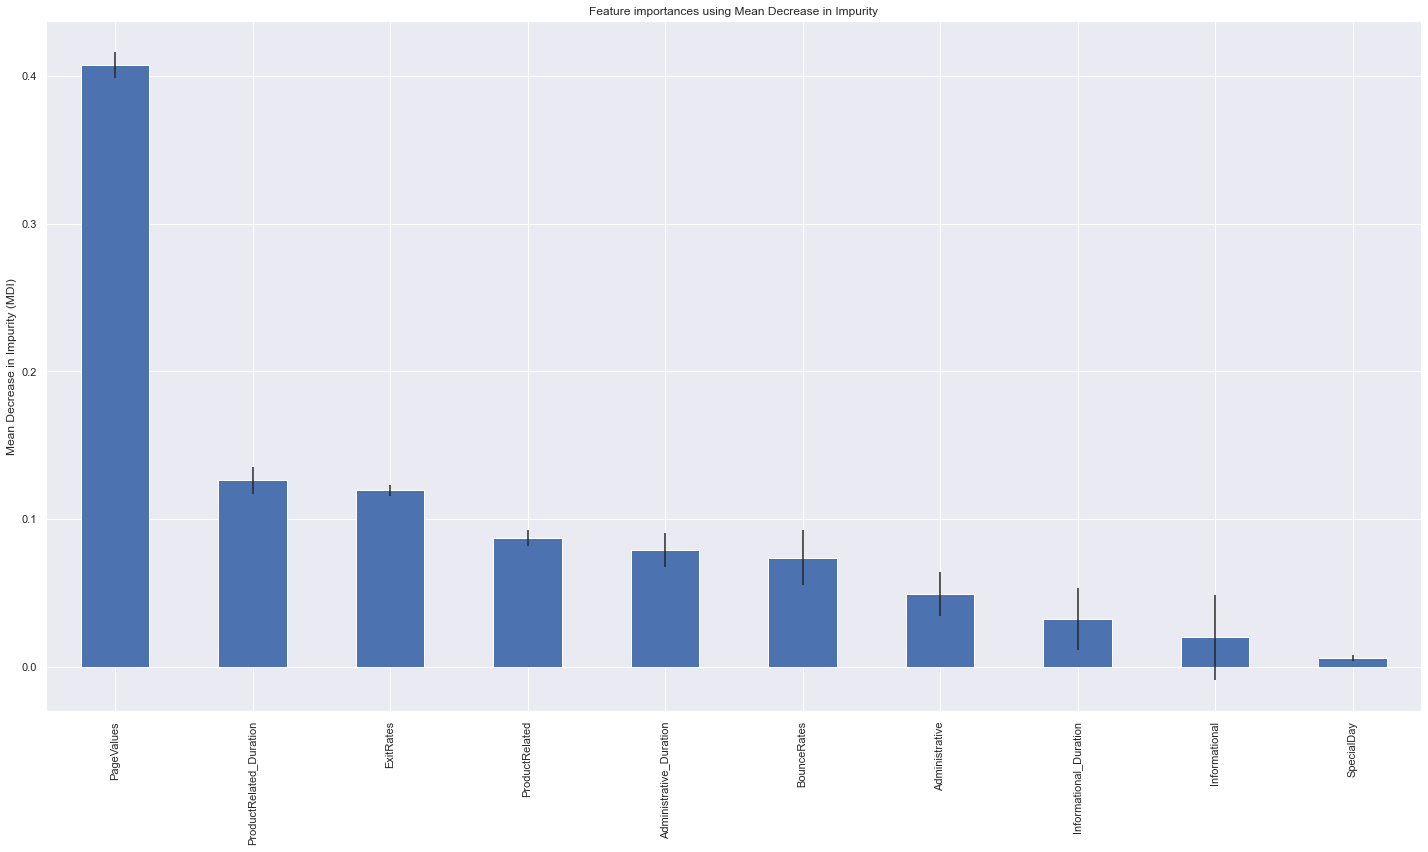

In [56]:
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
feature_importances = pd.Series(clf.feature_importances_, index=customer_data.keys()[0:10]).sort_values(ascending=False)

fig, ax = plt.subplots()
feature_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using Mean Decrease in Impurity")
ax.set_ylabel("Mean Decrease in Impurity (MDI)")
fig.tight_layout()

In [ ]:
# ideas in mind:
# - in order to see if there are collinear variables, in which case we should just pick the one that leads to the
# highest information? has the highest predictive power?
# - 

In [ ]:
# Just throw freaking random forests at it and see what happens